In [1]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

In [75]:
# File saved to: ./logs/vgg16/imagenet/int8/faults_network_rb/r0.001/stats/4.pkl
def get_results_dir(model_name, dataset_name, data_type, fault_type):
    d = {
        'vgg16': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/vgg16/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/vgg16/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/vgg16/imagenet/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_parity_avg': './logs/vgg16/imagenet/int8/faults_network_rb_parity_avg',
                },
               
            }
        },
        'vgg16_bn': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/vgg16_bn/imagenet/int8/faults_network_rb',
                },
               
            }
        },
         'resnet18': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/resnet18/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/resnet18/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/resnet18/imagenet/int8/faults_network_rb_parity_zero',
                },
               
            }
        }
        
    }
    return d.get(model_name).get(dataset_name).get(data_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, data_type):
    d = {
        'vgg16': {
            'imagenet': {
                'int8': 79.36, 
              }},
        'vgg16_bn': {
            'imagenet': {
                'int8': 80.14, 
              }},
        'resnet18': {
            'imagenet': {
                'int8': 76.46, 
              }},
        }
        
    return d[model_name][dataset_name][data_type]

# model_name = 'vgg16'
model_name = 'resnet18'
dataset_name = 'imagenet'

data_types = ['int8']
fault_types = ['faults_network_rb', 'faults_network_rb_ps1', 
               'faults_network_rb_parity_zero']#, 'faults_network_rb_parity_avg']
# fault_types = ['faults_layer', 'faults_layer_masking']


In [76]:
def parse_log(log_path):
#     trial: 4, n_faults: 1106753, total_params: 138344128, flipped_bits: 1106753 (1.00e-03), 
# changed_params: 1102905 (7.97e-03), test_time: 369, test_accuracy: 58.680000

    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item:
                        test_accuracy = round(float(item.split()[1]), 2)
                    if 'trial' in item:
                        trial = int(item.split()[1])
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    print('Finish log_path:', log_path, result.shape)
    return result 

def load_results(data_type, fault_type):
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, data_type, fault_type)
    if not results_dir:
        return None 
    
    # get number of bits folder
    for nbits_folder in os.listdir(results_dir):
        nbits = float(nbits_folder[1:])
        log_path = os.path.join(results_dir, nbits_folder, 'logs.txt')
        if os.path.isfile(log_path):
            results[nbits] = parse_log(log_path)
    return results 
        
data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for data_type in data_types:
    data[data_type] = {} 
    for fault_type in fault_types:
        results = load_results(data_type, fault_type)
        if results:
            data[data_type][fault_type] = results 


# print(data[data_type][fault_type][0.0001].shape)


Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb/r1e-06/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb/r1e-05/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb/r0.001/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb/r0.0001/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb/r1e-07/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb_ps1/r1e-06/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb_ps1/r1e-05/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb_ps1/r0.001/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb_ps1/r0.0001/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb_ps1/r1e-07/logs.txt (10, 3)
Finish log_path: ./logs/resnet18/imagenet/int8/faults_network_rb_parity_zero/r1e-06/logs

In [77]:
import torch 

model_path = './logs/'+ model_name +'/' + dataset_name +'/int8/quantized.pth.tar'
checkpoint = torch.load(model_path)
prec1 = checkpoint['prec1']
print('prec1:%.2f' %(prec1))
state_dict = checkpoint['state_dict']
param_id_to_name = {}
param_id_to_shape = {} 
param_id = 0 
weights_ids = []

for key in state_dict:
    tensor = state_dict[key]
    if len(tensor.size()) >= 2:
        weights_ids.append(param_id)
        param_id_to_shape[param_id] = tuple(tensor.size())
        
    if 'weight' in key or 'bias' in key:
        param_id_to_name[param_id] = key
        param_id += 1
#     if len(tensor.size()) < 2:
#         continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     tensor = tensor.cpu().numpy().ravel()
#     print([int(x) for x in tensor[:50]])
#     plt.hist(tensor, bins=100)
# #     plt.plot(tensor.cpu().numpy().ravel())
#     zeros = sum([x==0 for x in tensor])
#     plt.title(key+' [%d, %d], zero:%.2f' %(minv, maxv, zeros/len(tensor)))
#     plt.show()

prec1:76.46


In [78]:
print(len(param_id_to_name))
for weight_id in weights_ids:
    print('layer_id:', weight_id//3, 
          ', shape:', param_id_to_shape[weight_id], 
          ', #values:', np.prod(param_id_to_shape[weight_id]))

62
layer_id: 0 , shape: (64, 3, 7, 7) , #values: 9408
layer_id: 1 , shape: (64, 64, 3, 3) , #values: 36864
layer_id: 2 , shape: (64, 64, 3, 3) , #values: 36864
layer_id: 3 , shape: (64, 64, 3, 3) , #values: 36864
layer_id: 4 , shape: (64, 64, 3, 3) , #values: 36864
layer_id: 5 , shape: (128, 64, 3, 3) , #values: 73728
layer_id: 6 , shape: (128, 128, 3, 3) , #values: 147456
layer_id: 7 , shape: (128, 64, 1, 1) , #values: 8192
layer_id: 8 , shape: (128, 128, 3, 3) , #values: 147456
layer_id: 9 , shape: (128, 128, 3, 3) , #values: 147456
layer_id: 10 , shape: (256, 128, 3, 3) , #values: 294912
layer_id: 11 , shape: (256, 256, 3, 3) , #values: 589824
layer_id: 12 , shape: (256, 128, 1, 1) , #values: 32768
layer_id: 13 , shape: (256, 256, 3, 3) , #values: 589824
layer_id: 14 , shape: (256, 256, 3, 3) , #values: 589824
layer_id: 15 , shape: (512, 256, 3, 3) , #values: 1179648
layer_id: 16 , shape: (512, 512, 3, 3) , #values: 2359296
layer_id: 17 , shape: (512, 256, 1, 1) , #values: 131072
la

In [79]:
# print(data)

[1e-07, 1e-06, 1e-05, 0.0001, 0.001]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001]
[1e-07, 1e-06, 1e-05, 0.0001, 0.001]


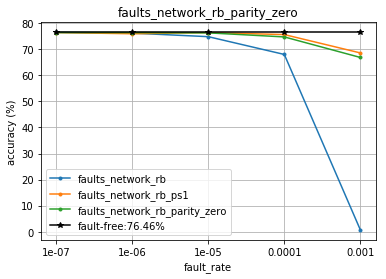

In [80]:
# x: fault_rate, y:accuracy; 

for data_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, data_type)
    xticks = ([], [])
    for fault_type in fault_types:

        res = data[data_type][fault_type]
        fault_rates = sorted(res.keys())
        print(fault_rates)

        num_values = res[fault_rates[0]][0, 0]
        x = np.log10(fault_rates)

        accuracies = [np.min(res[n_bits], axis=0)[-1] for n_bits in fault_rates]
        plt.plot(x, accuracies, label=fault_type, marker='.')
        if len(x) > len(xticks[0]):
            xticks = (x, [s for s in map(str, fault_rates)])
#         plt.ylim(0.927, 0.94)
    plt.grid()
    plt.ylabel('accuracy (%)')
    plt.xlabel('fault_rate')
    plt.title('%s' %(fault_type))
    plt.xticks(xticks[0], xticks[1])
    plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k', 
             label='fault-free:%.2f%%' %(fault_free_accuracy))
    plt.legend()    
    plt.show()


[(1e-07, -0.02), (1e-06, 0.28), (1e-05, 1.64), (0.0001, 8.46), (0.001, 75.78)]
[(1e-07, 0.06), (1e-06, 0.52), (1e-05, 0.08), (0.0001, 0.84), (0.001, 7.88)]
[(1e-07, 0.06), (1e-06, 0.08), (1e-05, 0.18), (0.0001, 1.74), (0.001, 9.62)]


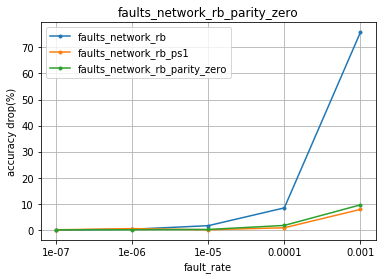

In [81]:
# x: fault_rate, y:accuracy drop; 
for data_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, data_type)
    xticks = ([], [])
    for fault_type in fault_types:

        res = data[data_type][fault_type]
        fault_rates = sorted(res.keys())
        x = np.log10(fault_rates)

        drops = [fault_free_accuracy - np.min(res[n_bits], axis=0)[-1] for n_bits in fault_rates]
        plt.plot(x, drops, marker='.', label=fault_type)
        
        print(list(zip(fault_rates, [round(d, 2) for d in drops])))
        if len(x) > len(xticks[0]):
            xticks = (x, [s for s in map(str, fault_rates)])
#         plt.ylim(0.927, 0.94)
    plt.grid()
    plt.ylabel('accuracy drop(%)')
    plt.xlabel('fault_rate')
    plt.title('%s' %(fault_type))
    plt.xticks(xticks[0], xticks[1])
    plt.legend()
    plt.show()


fault_type fault_rate      0      1      2      3      4
        rb      1e-07  76.48  76.58  76.54  76.48  76.56  76.52  76.58  76.74  76.52  76.56 
        rb      1e-06  76.52  76.46  76.54  76.70  76.68  76.34  76.64  76.18  76.60  76.60 
        rb      1e-05  76.42  76.26  75.78  74.82  76.14  76.64  75.88  76.18  75.84  76.38 
        rb     0.0001  73.54  72.92  72.36  74.20  72.94  68.00  70.76  71.76  70.02  72.54 
        rb      0.001   3.24   1.62   4.62   4.20   7.84   2.64   0.68   1.20   5.56   4.88 
       ps1      1e-07  76.40  76.54  76.50  76.50  76.56  76.46  76.64  76.58  76.56  76.56 
       ps1      1e-06  76.56  76.24  76.56  76.84  76.40  76.42  76.62  75.94  76.58  76.62 
       ps1      1e-05  76.58  76.56  76.38  76.62  76.58  76.74  76.58  76.50  76.42  76.56 
       ps1     0.0001  76.60  76.38  76.48  76.68  75.62  75.94  76.42  76.22  76.18  76.08 
       ps1      0.001  72.70  74.20  73.54  74.44  74.00  72.84  74.24  73.96  74.66  68.58 
      zero   

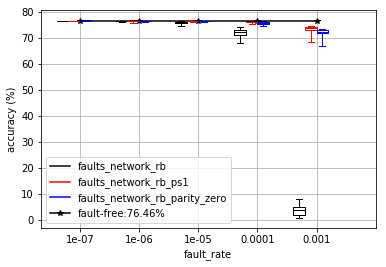

In [82]:
# x: fault_rate, y:accuracy; lengends: param_id 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    

for model_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    fault_rates = sorted(data[model_type][fault_types[0]].keys())
    colors = ['k', 'r', 'b', 'g'] 
    n_space = len(fault_types)
    offset = -0.3*n_space
    print('%10s %10s %6s %6s %6s %6s %6s' 
          %('fault_type', 'fault_rate', '0', '1', '2', '3', '4'))
    
    
    for i, fault_type in enumerate(fault_types):
        accuracies = [data[model_type][fault_type][fr][:, 2] for fr in fault_rates 
                      if fr in data[model_type][fault_type]]
#             print('fault_type:', fault_type)
        for a, b in zip(fault_rates, accuracies):
            b = ['%.2f' %(v) for v in b]
            bstr_format = '%6s '*len(b)
            print_format = '%10s %10s '+bstr_format
            print( print_format %(fault_type.split('_')[-1], a, *b))
        bpl = plt.boxplot(accuracies, 
                          positions=np.array(range(len(accuracies)))*n_space+offset, 
                          sym='', widths=0.6, whis='range')
        offset += 0.6
        set_box_color(bpl, colors[i]) 
#         print([data[model_type][fault_type][param_id][fr][0, :] for fr in fault_rates])

    # draw temporary red and blue lines and use them to create a legend
    for i, fault_type in enumerate(fault_types):
        plt.plot([], c=colors[i], label=fault_type)

    x = range(0, len(fault_rates) * n_space, n_space)
    plt.xticks(x, [str(fault_rate) for fault_rate in fault_rates])

    plt.xlim(-2, len(fault_rates)*n_space)
#     plt.ylim(0.927, 0.94)
    plt.grid()
    plt.ylabel('accuracy (%)')
    plt.xlabel('fault_rate')
    plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k', 
             label='fault-free:%.2f%%' %(fault_free_accuracy))   
    plt.legend()
    plt.show()


['faults_network_rb', 'faults_network_rb_ps1', 'faults_network_rb_parity_zero']
fault_type fault_rate      0      1      2      3      4
        rb      1e-07  -0.02  -0.12  -0.08  -0.02  -0.10  -0.06  -0.12  -0.28  -0.06  -0.10 
        rb      1e-06  -0.06   0.00  -0.08  -0.24  -0.22   0.12  -0.18   0.28  -0.14  -0.14 
        rb      1e-05   0.04   0.20   0.68   1.64   0.32  -0.18   0.58   0.28   0.62   0.08 
        rb     0.0001   2.92   3.54   4.10   2.26   3.52   8.46   5.70   4.70   6.44   3.92 
        rb      0.001  73.22  74.84  71.84  72.26  68.62  73.82  75.78  75.26  70.90  71.58 
       ps1      1e-07   0.06  -0.08  -0.04  -0.04  -0.10   0.00  -0.18  -0.12  -0.10  -0.10 
       ps1      1e-06  -0.10   0.22  -0.10  -0.38   0.06   0.04  -0.16   0.52  -0.12  -0.16 
       ps1      1e-05  -0.12  -0.10   0.08  -0.16  -0.12  -0.28  -0.12  -0.04   0.04  -0.10 
       ps1     0.0001  -0.14   0.08  -0.02  -0.22   0.84   0.52   0.04   0.24   0.28   0.38 
       ps1      0.001   3.

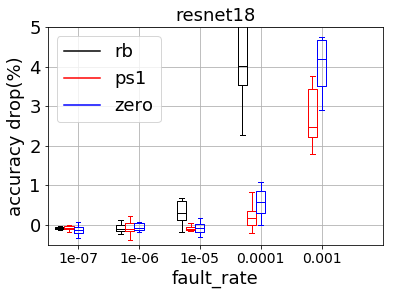

In [83]:
# x: fault_rate, y:accuracy drop; lengends: param_id 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
print(fault_types)
fontsize = 18 
for model_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    fault_rates = sorted(data[model_type][fault_types[0]].keys())
    colors = ['k', 'r', 'b', 'g'] 
    offset = -1.2
    print('%10s %10s %6s %6s %6s %6s %6s' 
          %('fault_type', 'fault_rate', '0', '1', '2', '3', '4'))
    for i, fault_type in enumerate(fault_types):
        accuracies = [fault_free_accuracy - data[model_type][fault_type][fr][:, 2] for fr in fault_rates
                     if fr in data[model_type][fault_type]]
#             print('fault_type:', fault_type)
        for a, b in zip(fault_rates, accuracies):
            b = ['%.2f' %(v) for v in b]
            bstr_format = '%6s '*len(b)
            print_format = '%10s %10s '+bstr_format
            print( print_format %(fault_type.split('_')[-1], a, *b))
        bpl = plt.boxplot(accuracies, 
                          positions=np.array(range(len(accuracies)))*4.0+offset, 
                          sym='', widths=0.6) #, whis='range')
        offset += 0.6
        set_box_color(bpl, colors[i]) 
#         print([data[model_type][fault_type][param_id][fr][0, :] for fr in fault_rates])

    # draw temporary red and blue lines and use them to create a legend
    for i, fault_type in enumerate(fault_types):
        plt.plot([], c=colors[i], label=fault_type.split('_')[-1])

    x = range(0, len(fault_rates) * 4, 4)
    plt.xticks(x, [str(fault_rate) for fault_rate in fault_rates], fontsize=14)
    plt.yticks(fontsize=fontsize)
    plt.xlim(-2, len(fault_rates)*4)
    plt.ylim(-0.5, 5)
    plt.grid()
    plt.ylabel('accuracy drop(%)', fontsize=fontsize)
    plt.xlabel('fault_rate', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.title(model_name, fontsize=fontsize)
    plt.show()

In [46]:
import pickle 
def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))

def parse_stats_dict(stats):
    # input format:
    # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
    # output format: 
    # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
    param_stats = {'changed_params':0, 
                   'flip_to_one': np.zeros(8, dtype='int'), 
                   'flip_to_zero': np.zeros(8, dtype='int'),
                  'value_before_flip': [],
                  'value_after_flip':[], 
                  'flipped_positions': []}
    for weight_id, value_dict in stats.items():       
        for value_id, flip_list in value_dict.items():
            param_stats['changed_params'] += 1
            param_stats['value_before_flip'].append(flip_list[0][0])
            param_stats['value_after_flip'].append(flip_list[-1][-1])
            param_stats['flipped_positions'].append([x[1] for x in flip_list])

            for _, flip_pos, flip_bit, flip_value in flip_list:
                if flip_bit:
                    param_stats['flip_to_one'][flip_pos] += 1
                else:
                    param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def parse_stats(stats):
    param_stats = {'changed_params':0, 
                   'flip_to_one': np.zeros(8, dtype='int'), 
                   'flip_to_zero': np.zeros(8, dtype='int'),
                  'value_before_flip': [],
                  'value_after_flip':[], 
                   'value_after_correction':[],
                  'flipped_positions': []}
    for weight_id, value_tuple in stats.items(): 
        if isinstance(value_tuple, tuple):
            value_dict, corr_dict = value_tuple 
        else:
            value_dict, corr_dict = value_tuple, None 
        
        for value_id, flip_list in value_dict.items():
            param_stats['changed_params'] += 1
            param_stats['value_before_flip'].append(flip_list[0][0])
            param_stats['value_after_flip'].append(flip_list[-1][-1])
            param_stats['flipped_positions'].append([x[1] for x in flip_list])
            
            if corr_dict:
                if value_id in corr_dict:
                    assert corr_dict[value_id][0] == flip_list[-1][-1]
                    param_stats['value_after_correction'].append(corr_dict[value_id][-1])
                else:
                    param_stats['value_after_correction'].append(flip_list[-1][-1])

            for _, flip_pos, flip_bit, flip_value in flip_list:
                if flip_bit:
                    param_stats['flip_to_one'][flip_pos] += 1
                else:
                    param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def trial_id_to_stats_files(trial_id):
    return str(trial_id)+'.pkl' 

def load_and_average_stats(results_dir, trial_ids):
    stat_dir = os.path.join(results_dir, 'stats')
    stats_files = map(trial_id_to_stats_files, trial_ids)
    avg_param_stats = None 
    for f in stats_files:
        # each trial is saved as a pickle 
        stats = load_pickle(stat_dir, f, verbose=False)
        print('stats', stats)
        param_stats = parse_stats(stats)
        if avg_param_stats:
            for key, value in param_stats.items():
                avg_param_stats[key] += value 
        else:
            avg_param_stats = param_stats
    return avg_param_stats
                    


fault_type: faults_network_rb
accuracies: [79.36 79.24 79.12 79.02 79.18 79.38 79.32 79.26 79.04 79.08]
stats {13: defaultdict(<class 'list'>, {90215297: [(-8, 0, False, 120)], 82652946: [(1, 1, True, 65)], 787699: [(6, 0, True, -122)], 57182870: [(3, 3, True, 19)], 22654902: [(13, 0, True, -115)], 20786679: [(4, 7, True, 5)], 53874027: [(3, 0, True, -125)], 39669887: [(-23, 1, False, -87)], 67435839: [(5, 6, True, 7)]}), 14: defaultdict(<class 'list'>, {14182454: [(5, 4, True, 13)], 8081183: [(17, 3, False, 1)]})}
flip_to_one: [3 1 0 1 1 0 1 1], flip_to_zero: [1 1 0 1 0 0 0 0]
#changed_values: 11 , #flipped_bits: 11 , #changed_values: 11 , #flipped_bits: 11
6 [(-8, [0], 120), (1, [1], 65), (6, [0], -122), (13, [0], -115), (3, [0], -125), (-23, [1], -87)]

fault_type: faults_network_rb_ps1
accuracies: [79.36 79.32 79.36 79.36 79.36 79.42 79.32 79.34 79.02 79.14]
stats {13: (defaultdict(<class 'list'>, {90215297: [(-8, 0, False, 120)], 82652946: [(1, 1, True, 65)], 787699: [(6, 0, True

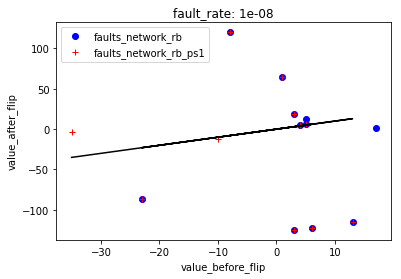

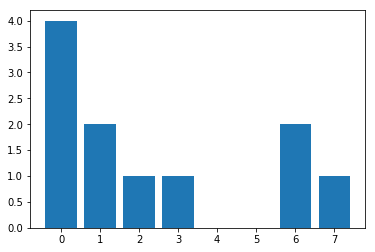

In [171]:

model_type = 'int8'
fault_rate = 0.00000001
markers = ['o', '+']
colors = ['b', 'r']
for fi, fault_type in enumerate(fault_types):
    print('\nfault_type:', fault_type)
    print('accuracies:', data[model_type][fault_type][fault_rate][:, 2])

    folder = 'r%s' %( fault_rate)
    results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

    avg_params_stats = load_and_average_stats(results_dir, [0])
    # print(avg_params_stats)
    print('flip_to_one: %s, flip_to_zero: %s' 
          %(avg_params_stats['flip_to_one'], avg_params_stats['flip_to_zero']))
    
    print('#changed_values:', len(avg_params_stats['value_before_flip']), 
          ', #flipped_bits:', sum(avg_params_stats['flip_to_one'])+sum(avg_params_stats['flip_to_zero']),
         ', #changed_values:', len(avg_params_stats['flipped_positions']),
         ', #flipped_bits:',sum([len(x) for x in avg_params_stats['flipped_positions']]))
    
#     num_values_show = 100 
#     print(list(zip(avg_params_stats['value_before_flip'][:num_values_show], 
#                    avg_params_stats['flipped_positions'][:num_values_show],
#                    avg_params_stats['value_after_flip'][:num_values_show])))

    check = [(avg_params_stats['value_before_flip'][i], 
                  avg_params_stats['flipped_positions'][i], 
                 avg_params_stats['value_after_flip'][i]) 
             for i, item in enumerate(avg_params_stats['flipped_positions'])
                                     if (0 in item or 1 in item or 2 in item) and 
            avg_params_stats['value_before_flip'][i]!=avg_params_stats['value_after_flip'][i]]
    print(len(check), check)
    
    plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 
             marker=markers[fi], label=fault_type, linestyle='', color=colors[fi])
    plt.xlabel('value_before_flip')
    plt.ylabel('value_after_flip')
    
    
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_before_flip'], 'k-')
plt.legend()
plt.title('fault_rate: %s' %(fault_rate))
plt.show()

import collections 
counter = collections.Counter([x for y in avg_params_stats['flipped_positions'] for x in y ])
counts = sorted(counter.items(), key=lambda x: x[0])
counts = list(zip(*counts))
plt.bar(counts[0], counts[1])
plt.show()
             
                               

In [54]:
# import torch 

# model_path = './logs/vgg16/cifar10/int8/quantized.pth.tar'
# checkpoint = torch.load(model_path)
# prec1 = checkpoint['prec1']
# print('prec1:', prec1)
# state_dict = checkpoint['state_dict']
# for key in state_dict:
#     tensor = state_dict[key]
#     if len(tensor.size()) < 2:
#         continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     plt.hist(tensor.cpu().numpy().ravel(), bins=100)
#     plt.title(key+' [%d, %d]' %(minv, maxv))
#     plt.show()